# 演習課題その３ リンク解析
## 必須課題(1) PageRankアルゴリズムの確認
まずP12のグラフを作成する

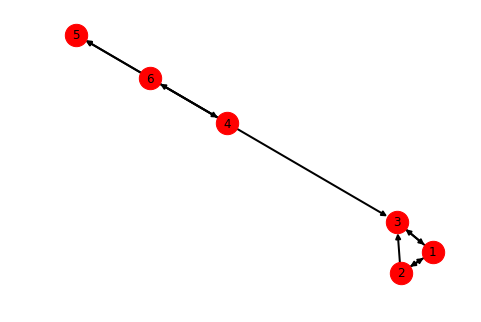

In [24]:
import numpy as np
import numpy.linalg as lg
import networkx as nx
import matplotlib.pyplot as plt
%matplotlib inline
%precision 2

G = nx.DiGraph()
G.add_nodes_from([1,2,3,4,5,6])
G.add_edges_from([
    (1, 2), (1, 3),
    (2, 1), (2, 3),
    (3, 1),
    (4, 3), (4, 5), (4, 6),
    (6, 4), (6, 5)
])
pos = nx.spring_layout(G, k=0.3)
nx.draw(G, with_labels=True, node_size=500, width=2, node_color="R")
plt.show()

少し見づらいが、そのまま使用する。遷移行列が確率行列の性質を満たすためには、どのノードからも一つは出リンクが存在している必要性がある。与えられた例と同様に、今回は、出リンクを持っていない５番ノードに、全ノードに対する出リンクを与える。すると、次のようなグラフが得られる。

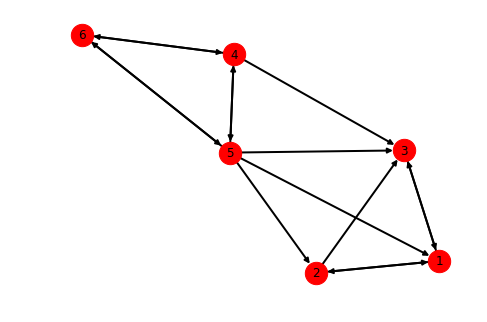

In [25]:
G.add_edges_from([
    (5,1),(5,2),(5,3),(5,4),(5,5),(5,6)
])
pos = nx.spring_layout(G, k=0.3)
nx.draw(G, with_labels=True, node_size=500, width=2, node_color="R")
plt.show()

このグラフに対して、べき乗法を適用してPageRankを計算する。今回はNetworkXの機能を利用することにした。結果は以下の出力である。

In [26]:
p = nx.pagerank(G, alpha=0.85, tol=1e-6)
p

{1: 0.35, 2: 0.19, 3: 0.28, 4: 0.06, 5: 0.07, 6: 0.05}

続いて、複数の初期分布に対してPageRankを計算、同じ結果が得られるかどうかを確認する。初期分布を変更するため、pagerankの計算関数を定義する。与えられた例にあった関数の拡張であり、実行するたびにランダムに初期分布を変化させる。

In [27]:
def rand_pagerank(A, d = 0.85, eps = 1e-6):
    n = A.shape[0]  
    e = np.ones(A.shape[0])
    #ランダムな整数のn次元ベクトルを生成し、それを全要素の和で割ることにより合計値を１に抑制
    #ランダムな値を持つ初期分布を生成する
    rand_n = np.random.randint(0, 1000, n)
    p = rand_n / np.sum(rand_n)
    print("初期分布: ", p)
    while True: 
        p_next = d * np.dot(A.T, p) + (1.0 - d) * e / n 
        if lg.norm(p_next - p, ord=1) <= eps: 
            p = p_next
            break
        p = p_next
    return p

上記グラフから確率行列Aを定義し、rand_pagerankにより複数回ランダムの初期分布で実行、結果を確認する。

In [28]:
A = np.array([
    [0, 1/2, 1/2, 0, 0, 0],
    [1/2, 0, 1/2, 0, 0, 0],
    [1, 0, 0, 0, 0, 0],
    [0, 0, 1/3, 0, 1/3, 1/3],
    [1/6, 1/6, 1/6, 1/6, 1/6, 1/6],
    [0, 0, 0, 1/2, 1/2, 0]
])
rand_pagerank(A, d = 0.85, eps = 1e-6)

初期分布:  [0.12 0.02 0.33 0.12 0.19 0.21]


array([0.35, 0.19, 0.28, 0.06, 0.07, 0.05])

上記の通り、ランダムな初期分布を用いて先程と同様の結果が得られた。念の為、１０回ほど実行してみる。

In [29]:
for i in range(9):
    p = rand_pagerank(A, d = 0.85, eps = 1e-6)
    print("pagerank値: ", p)
    print("\n")

初期分布:  [0.02 0.3  0.24 0.11 0.04 0.28]
pagerank値:  [0.35 0.19 0.28 0.06 0.07 0.05]


初期分布:  [0.24 0.02 0.22 0.07 0.24 0.2 ]
pagerank値:  [0.35 0.19 0.28 0.06 0.07 0.05]


初期分布:  [0.29 0.07 0.35 0.05 0.21 0.03]
pagerank値:  [0.35 0.19 0.28 0.06 0.07 0.05]


初期分布:  [0.21 0.19 0.06 0.22 0.28 0.05]
pagerank値:  [0.35 0.19 0.28 0.06 0.07 0.05]


初期分布:  [0.31 0.   0.23 0.33 0.05 0.07]
pagerank値:  [0.35 0.19 0.28 0.06 0.07 0.05]


初期分布:  [0.2  0.13 0.17 0.15 0.14 0.22]
pagerank値:  [0.35 0.19 0.28 0.06 0.07 0.05]


初期分布:  [0.25 0.08 0.25 0.02 0.24 0.16]
pagerank値:  [0.35 0.19 0.28 0.06 0.07 0.05]


初期分布:  [0.22 0.16 0.2  0.19 0.12 0.12]
pagerank値:  [0.35 0.19 0.28 0.06 0.07 0.05]


初期分布:  [0.19 0.21 0.41 0.03 0.13 0.04]
pagerank値:  [0.35 0.19 0.28 0.06 0.07 0.05]




ランダムな初期分布でありながら、いずれの試行も一つのpagerank値に収束していることが結果から分かった。

# 必須課題(2) 定常分布
非周期的でない既約なグラフを用意する。単純なグラフで非周期的でないものは、ある一つのノードを中心に考え、そこからどのエッジに進んだとしても同じだけ進んで同じだけ戻ってくるようなグラフが考えられる。今回用いるグラフはノード１から周期的になるように考えた。グラフは以下の通りである。ノード１から出発すると必ず４の倍数分エッジをすすんで１に戻ってくる。

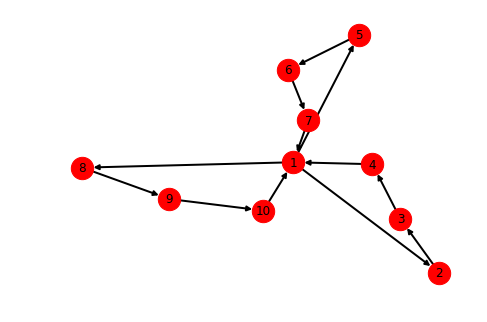

In [30]:
aperiodic_G = nx.DiGraph()
aperiodic_G.add_nodes_from([1,2,3,4,5,6,7,8,9,10])
aperiodic_G.add_edges_from([
    (1, 2), (2, 3), (3, 4), (4, 1),
    (1, 5), (5, 6), (6, 7), (7, 1),
    (1, 8), (8, 9), (9, 10), (10, 1)
])
pos = nx.spring_layout(aperiodic_G, k=0.4)
nx.draw(aperiodic_G, with_labels=True, node_size=500, width=2, node_color="R")
plt.show()

続いて、テレポーテーションを用いないべき乗法を実行する関数を作成する。先程のランダムな初期分布を持つ関数のテレポーテーション部分を削除したものを使用する。収束しない可能性があるので、引数のlimit回を上限に計算を行うこととする。

In [31]:
def aperiodic_pagerank(A, d = 0.85, eps = 1e-6, limit=100):
    n = A.shape[0]  
    e = np.ones(A.shape[0])
    rand_n = np.random.randint(0, 1000, n)
    p = rand_n / np.sum(rand_n)
    print("初期分布: ", p)
    for i in range(limit): 
        p_next = d * np.dot(A.T, p)
        if lg.norm(p_next - p, ord=1) <= eps: 
            p = p_next
            break
        p = p_next
    return p

遷移行列aperiodic_Aを作成し、以下に実際に動作をさせてみる。limit=10, limit=100, limit=1000, limit=10000, limit=10000000で実行すると以下のような結果になった。

In [32]:
limit_list = [10, 100, 1000, 10000, 10000000]
aperiodic_A = np.array([
    [0, 1/3, 0, 0, 1/3, 0, 0, 1/3, 0, 0],
    [0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
    [1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
    [1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
    [1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
])

#通常のpagerankで収束値を検証する
p = rand_pagerank(aperiodic_A, d = 0.85, eps = 1e-6)
print("収束するpagerank値: ", p)

print("\n【以下検証する値】\n")
for lim in limit_list:
    print("試行回数: ", lim)
    p = aperiodic_pagerank(aperiodic_A, d = 0.85, eps = 1e-6, limit=lim)
    print("pagerank値: ", p)
    print("\n")

初期分布:  [0.08 0.05 0.1  0.12 0.15 0.14 0.07 0.14 0.03 0.11]
収束するpagerank値:  [0.24 0.08 0.08 0.09 0.08 0.08 0.09 0.08 0.08 0.09]

【以下検証する値】

試行回数:  10
初期分布:  [0.15 0.16 0.12 0.14 0.11 0.09 0.02 0.09 0.08 0.03]
pagerank値:  [0.06 0.01 0.01 0.02 0.01 0.01 0.02 0.01 0.01 0.02]


試行回数:  100
初期分布:  [0.19 0.04 0.02 0.14 0.17 0.08 0.06 0.18 0.   0.13]
pagerank値:  [3.35e-07 6.19e-08 1.27e-07 3.29e-08 6.19e-08 1.27e-07 3.29e-08 6.19e-08
 1.27e-07 3.29e-08]


試行回数:  1000
初期分布:  [0.04 0.   0.2  0.16 0.12 0.   0.15 0.11 0.19 0.02]
pagerank値:  [5.19e-08 9.19e-08 1.54e-07 1.29e-07 9.19e-08 1.54e-07 1.29e-07 9.19e-08
 1.54e-07 1.29e-07]


試行回数:  10000
初期分布:  [0.25 0.15 0.03 0.2  0.02 0.04 0.05 0.04 0.17 0.03]
pagerank値:  [1.11e-06 4.16e-07 4.77e-07 4.32e-07 4.16e-07 4.77e-07 4.32e-07 4.16e-07
 4.77e-07 4.32e-07]


試行回数:  10000000
初期分布:  [0.07 0.   0.2  0.05 0.11 0.18 0.1  0.06 0.17 0.05]
pagerank値:  [4.74e-07 5.81e-08 1.91e-08 4.85e-08 5.81e-08 1.91e-08 4.85e-08 5.81e-08
 1.91e-08 4.85e-08]




実施した結果は上記の通りである。どの結果も収束した値が得られていない事がわかる。

最も大きいlimitで、先程のように10回試行する。

In [33]:
for i in range(9):
    p = aperiodic_pagerank(aperiodic_A, d = 0.85, eps = 1e-6, limit=lim)
    print("pagerank値: ", p)
    print("\n")

初期分布:  [0.08 0.15 0.19 0.15 0.12 0.03 0.09 0.   0.11 0.09]
pagerank値:  [3.70e-07 1.54e-07 1.50e-07 3.48e-08 1.54e-07 1.50e-07 3.48e-08 1.54e-07
 1.50e-07 3.48e-08]


初期分布:  [0.1  0.12 0.04 0.1  0.01 0.03 0.2  0.14 0.18 0.08]
pagerank値:  [1.12e-07 1.05e-07 9.88e-08 1.51e-07 1.05e-07 9.88e-08 1.51e-07 1.05e-07
 9.88e-08 1.51e-07]


初期分布:  [0.07 0.   0.12 0.05 0.23 0.11 0.22 0.15 0.   0.04]
pagerank値:  [8.62e-08 1.51e-07 9.13e-08 1.22e-07 1.51e-07 9.13e-08 1.22e-07 1.51e-07
 9.13e-08 1.22e-07]


初期分布:  [0.23 0.02 0.09 0.18 0.08 0.04 0.15 0.07 0.11 0.04]
pagerank値:  [5.17e-07 1.25e-07 1.80e-07 2.75e-07 1.25e-07 1.80e-07 2.75e-07 1.25e-07
 1.80e-07 2.75e-07]


初期分布:  [0.02 0.09 0.12 0.14 0.17 0.1  0.12 0.05 0.08 0.11]
pagerank値:  [3.72e-07 7.38e-09 1.03e-07 9.90e-08 7.38e-09 1.03e-07 9.90e-08 7.38e-09
 1.03e-07 9.90e-08]


初期分布:  [0.12 0.11 0.09 0.08 0.12 0.13 0.15 0.03 0.04 0.12]
pagerank値:  [4.18e-07 1.94e-07 6.50e-08 1.45e-07 1.94e-07 6.50e-08 1.45e-07 1.94e-07
 6.50e-08 1.45e-07]


初期分布

どれも収束値を取っていないことが分かる。

## 考察
テレポーテーションを仮定することが、既約性と非周期性を満たすことに重要であることが直感的に理解可能である。
実際に、テレポーテーションを設定した手法では、この非周期的でないグラフでもちゃんと収束してpagerank値を出力出来るのに対して、テレポーテーションを設定しない手法では、何度試行しても収束しないという結果が得られた。

## 任意課題(1) Personalzied PageRank
Personalized PageRank値を計算する関数を用意する。
バイアスを掛けたいノード集合を入力として受け取り、そのノード番号と一致する箇所のみ、1/(集合の要素数)の値が立ち、他が０となるような行列を用いてバイアスを掛ける。

In [34]:
#バイアスを掛ける行列Vを作る。
#引数にバイアスを掛けたいノード番号にのみ１を立てて他はゼロのベクトルを与える
def calculate_V(A, bias_nodes):
    size = A.shape[0]
    V = np.zeros(A.shape[0])
    for elm in range(size):
        if bias_nodes[elm] == 1:
            V[elm] = 1 / np.count_nonzero(bias_nodes)
    return V

#personalized pagerankを計算する関数
#引数に以前のものに加えた先程のバイアスを掛けたいノード番号にのみ１を立てるベクトルを与える
def personalized_pagerank(A, bias_nodes, d = 0.85, eps = 1e-6, limit=100):
    n = A.shape[0]  
    e = np.ones(A.shape[0])
    rand_n = np.random.randint(0, 1000, n)
    p = rand_n / np.sum(rand_n)
    print("初期分布: ", p)
    V = calculate_V(A, bias_nodes)
    for i in range(limit): 
        p_next = d * np.dot(A.T, p) +(1.0 - d) * V / n
        if lg.norm(p_next - p, ord=1) <= eps: 
            p = p_next
            break
        p = p_next
    return p

バイアスを掛けたいノード番号を設定して実行する。今回は３と５と６にバイアスを掛けるように設定する。更に、バイアスのかかっていないページランク値とも比較を行った。

In [35]:
bias_nodes = [0, 0, 1, 0, 1, 1]

biased_p = personalized_pagerank(A, bias_nodes, 0.85, 1e-6, 10000)
print("personalized_pagerank値:", biased_p)
biased_p = personalized_pagerank(A, bias_nodes, 0.85, 1e-6, 10000)
print("personalized_pagerank値:", biased_p)
biased_p = personalized_pagerank(A, bias_nodes, 0.85, 1e-6, 10000)
print("personalized_pagerank値:", biased_p)

print("\n")

p = rand_pagerank(A, d = 0.85, eps = 1e-6)
print("バイアスのかかっていないpagerank値: ", p)

初期分布:  [0.39 0.25 0.07 0.   0.11 0.19]
personalized_pagerank値: [0.05 0.03 0.05 0.01 0.02 0.01]
初期分布:  [0.05 0.07 0.08 0.21 0.2  0.39]
personalized_pagerank値: [0.05 0.03 0.05 0.01 0.02 0.01]
初期分布:  [0.26 0.22 0.05 0.01 0.21 0.25]
personalized_pagerank値: [0.05 0.03 0.05 0.01 0.02 0.01]


初期分布:  [0.11 0.28 0.28 0.05 0.01 0.26]
バイアスのかかっていないpagerank値:  [0.35 0.19 0.28 0.06 0.07 0.05]


## 考察
バイアスをかけたページランク値もちゃんと収束することが確認できた。また、バイアスのかかっていないページランク値と比べて値が変化することも確認出来た。

１つ目のノードの値に対して、他のノードのページランク値を比較してみると、バイアスのかかっていないページランク値は、およそ[1, 0.54, 0.8, 0.17, 0.2, 0.14]となるのに対して、ノード３と５と６にバイアスのかかったパーソナライズドされたページランク値は、[1, 0.6, 1, 0.2, 0.4, 0.2]と、バイアスのかかっている箇所の値が大きく向上しているように思える。

実際にこのような効果が得られるかは複数のグラフの検証が必要である。